# Capstone F5 Week 3
## Sequential SVM→GP with Boundary Focus (HIGH values)

**Week 2:** 4062.11 (RANK 1 🥇, +6658% improvement!)  
**Pattern:** X3=1.0, X4=1.0, X2=0.968 → MAXIMIZE!  
**Strategy:** SVM + Boundary focus on HIGH values (>0.9)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
print('='*70)
print('CAPSTONE F5 WEEK 3')
print('='*70)

CAPSTONE F5 WEEK 3


## Load Data

In [2]:
X = np.load('f5_w3_inputs.npy')
Y = np.load('f5_w3_outputs.npy')

print(f'Data: {len(X)} samples, {X.shape[1]}D')
print(f'n/p: {len(X)/X.shape[1]:.2f}')
print(f'Best: {Y.max():.2f}')

w2_idx = np.argmax(Y)
w2_pt = X[w2_idx]
w2_val = Y[w2_idx]

print(f'\nWeek 2 Point (RANK 1):')
print(f'  Value: {w2_val:.2f}')
print(f'  Point: {w2_pt}')
print(f'  X2={w2_pt[1]:.3f} (HIGH), X3={w2_pt[2]:.3f} (MAX), X4={w2_pt[3]:.3f} (MAX)')

Data: 22 samples, 4D
n/p: 5.50
Best: 4062.11

Week 2 Point (RANK 1):
  Value: 4062.11
  Point: [0.299008 0.968298 1.       1.      ]
  X2=0.968 (HIGH), X3=1.000 (MAX), X4=1.000 (MAX)


## Train SVM

In [3]:
thr = np.percentile(Y, 70)
yb = (Y > thr).astype(int)

svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm.fit(X, yb)
cv = cross_val_score(svm, X, yb, cv=3)

print(f'SVM CV: {cv.mean():.1%} ± {cv.std():.1%}')

weights = svm.coef_[0]
print(f'\nSVM Weights (expect X2, X3, X4 positive):')
for i, w in enumerate(weights):
    direction = 'POSITIVE (want HIGH)' if w > 0 else 'NEGATIVE (want LOW)'
    print(f'  X{i+1}: {w:+.3f}  →  {direction}')

SVM CV: 82.7% ± 15.5%

SVM Weights (expect X2, X3, X4 positive):
  X1: -0.634  →  NEGATIVE (want LOW)
  X2: +0.859  →  POSITIVE (want HIGH)
  X3: +0.582  →  POSITIVE (want HIGH)
  X4: +1.778  →  POSITIVE (want HIGH)


## Train GP

In [4]:
kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, 
                              normalize_y=True, random_state=42)
gp.fit(X, Y)
print(f'GP R²: {gp.score(X, Y):.3f}')

GP R²: 0.876


## Generate Candidates - SVM + Boundary HIGH

In [5]:
print('\nGenerating candidates...')
np.random.seed(42)

# Generate global pool
Xc = np.random.uniform(0, 1, (10000, 4))
sp = svm.predict(Xc)
spr = svm.predict_proba(Xc)[:, 1]

# Get SVM-approved (60%)
if (sp == 1).sum() > 0:
    idx = np.where(sp == 1)[0]
    order = np.argsort(spr[idx])[::-1]
    X_svm = Xc[idx[order[:min(6000, len(idx))]]]
    print(f'SVM approved: {len(X_svm):,} / {(sp==1).sum():,}')
else:
    print('⚠️ No SVM-approved, using top by probability')
    X_svm = Xc[np.argsort(spr)[::-1][:6000]]

# Boundary HIGH candidates (40%)
print('\nGenerating boundary HIGH candidates...')
Xb = []
while len(Xb) < 4000:
    c = np.random.uniform(0, 1, 4)
    # At least one dimension > 0.9 (focus on HIGH values)
    if (c > 0.9).any():
        Xb.append(c)

Xb = np.array(Xb[:4000])
print(f'Boundary HIGH: {len(Xb):,}')

# Check boundary distribution
high_dims = (Xb > 0.9).sum(axis=1)
print(f'  Dims >0.9 per candidate: {high_dims.mean():.2f} avg')

X_filt = np.vstack([X_svm, Xb])
print(f'\nTotal: {len(X_filt):,} candidates')


Generating candidates...
SVM approved: 1,395 / 1,395

Generating boundary HIGH candidates...
Boundary HIGH: 4,000
  Dims >0.9 per candidate: 1.16 avg

Total: 5,395 candidates


## GP Optimization

In [6]:
def expected_improvement(Xn, gp, yb, xi=0.05):
    mu, sig = gp.predict(Xn, return_std=True)
    sig = np.maximum(sig, 1e-10)
    imp = mu - yb - xi
    Z = imp / sig
    ei = imp * norm.cdf(Z) + sig * norm.pdf(Z)
    ei[sig < 1e-10] = 0.0
    return ei

yb = Y.max()
ei = expected_improvement(X_filt, gp, yb, xi=0.05)
mu, sig = gp.predict(X_filt, return_std=True)

bi = np.argmax(ei)
x_next = X_filt[bi]

high_dims = (x_next > 0.9).sum()

print('='*70)
print('WEEK 3 RECOMMENDATION')
print('='*70)
print(f'\nPoint: {x_next}')
print(f'\nPredicted: {mu[bi]:.2f} ± {sig[bi]:.2f}')
print(f'Expected gain: {((mu[bi]/yb-1)*100):+.2f}%')
print(f'\nDimensions >0.9: {high_dims}/4')
print(f'Source: {"SVM-approved" if bi < len(X_svm) else "Boundary HIGH"}')

WEEK 3 RECOMMENDATION

Point: [0.80304613 0.94545055 0.99754776 0.97627006]

Predicted: 2572.64 ± 847.97
Expected gain: -36.67%

Dimensions >0.9: 3/4
Source: SVM-approved


## ACQUISITION FUNCTION VISUALIZATIONS

Creating acquisition curves...


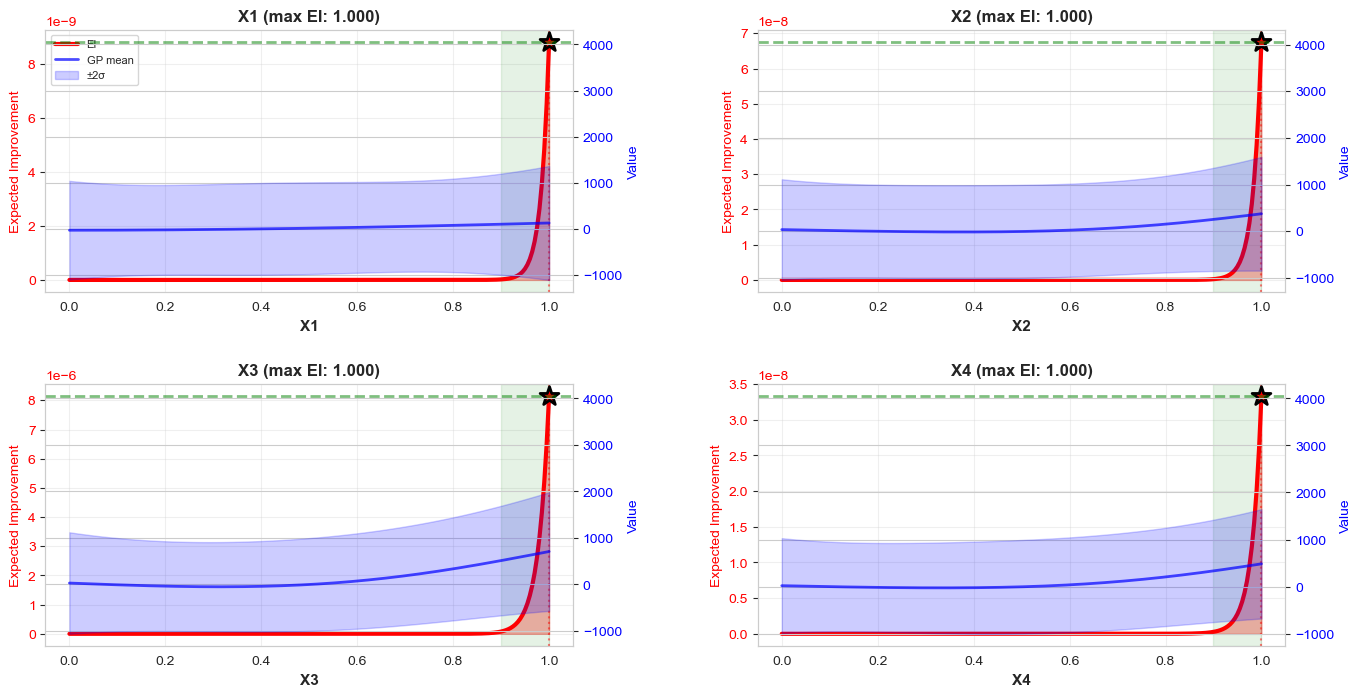

✓ Saved: Capstone_F5_W3_acquisition.png


In [7]:
print('Creating acquisition curves...')

n_dims = X.shape[1]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.35)

for dim in range(n_dims):
    ax = fig.add_subplot(gs[dim // 2, dim % 2])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, yb, 0.05)
    
    # GP plot
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7, label='GP mean')
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue', label='±2σ')
    ax2.axhline(yb, color='green', ls='--', alpha=0.5, lw=2)
    ax2.set_ylabel('Value', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot
    ax.plot(x1, e, 'r-', lw=3, label='EI')
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=200, marker='*', 
              zorder=5, edgecolors='black', lw=2)
    ax.axvline(x1[mi], color='red', ls=':', alpha=0.5)
    
    # Highlight if near boundary HIGH
    if x1[mi] > 0.9:
        ax.axvspan(0.9, 1.0, alpha=0.1, color='green')
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold', fontsize=11)
    ax.set_ylabel('Expected Improvement', color='red', fontsize=10)
    ax.set_title(f'X{dim+1} (max EI: {x1[mi]:.3f})', fontweight='bold', fontsize=12)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xlim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    
    if dim == 0:
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.savefig('Capstone_F5_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: Capstone_F5_W3_acquisition.png')

## RESULTS VISUALIZATION

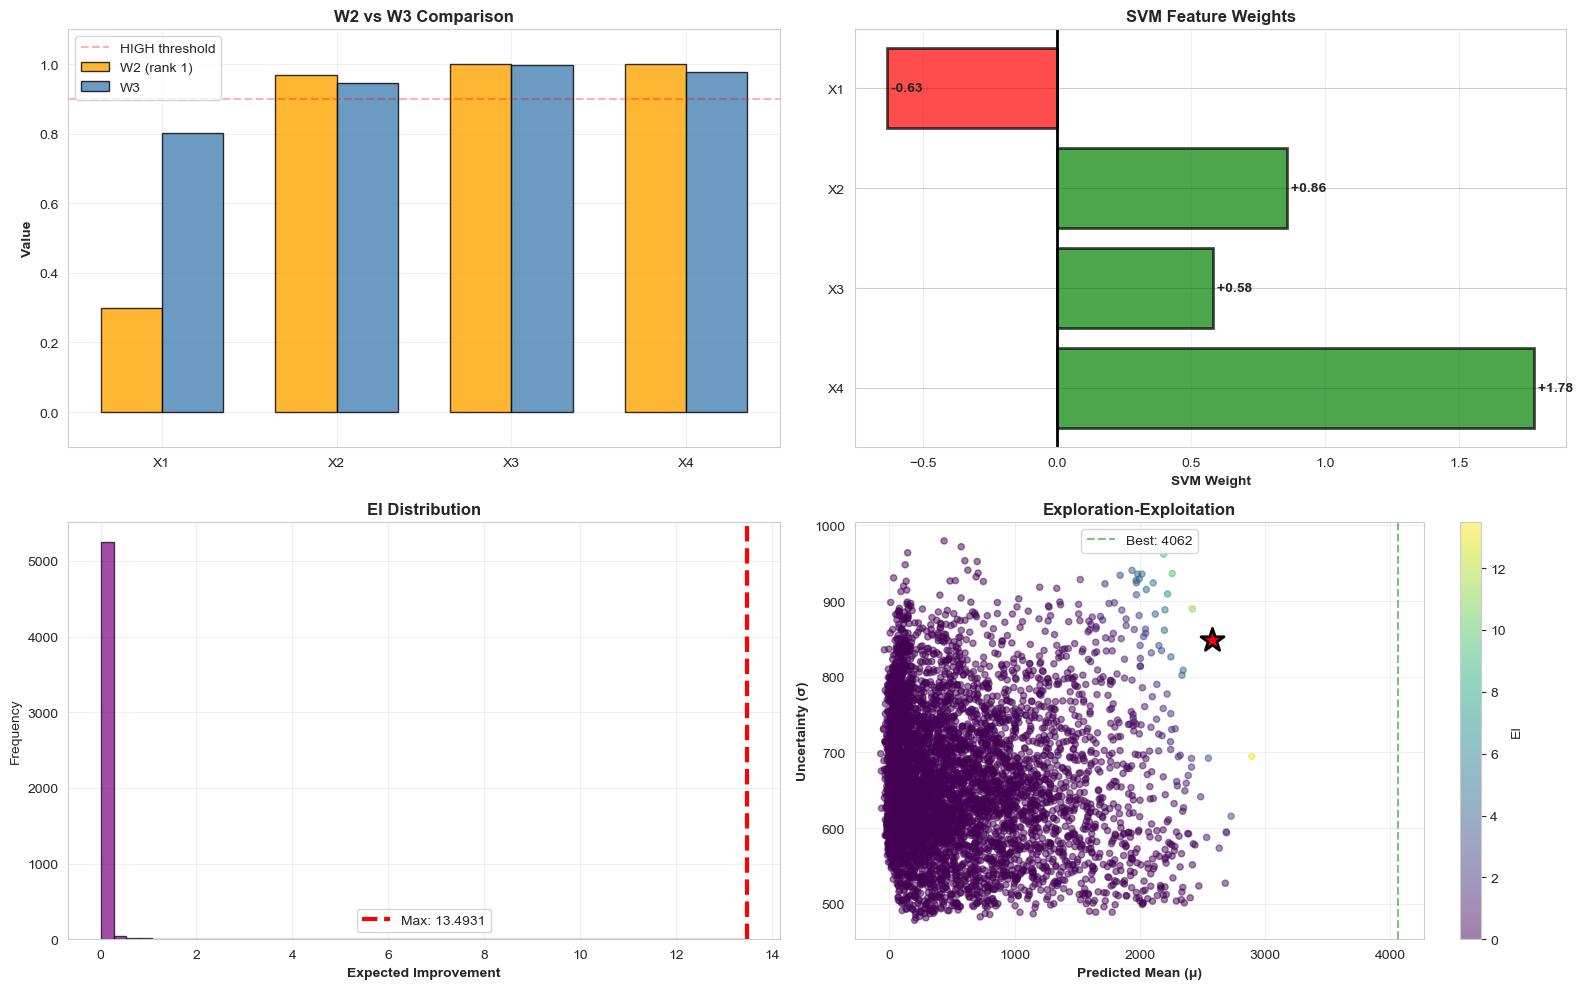

✓ Saved: Capstone_F5_W3_results.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

dims = np.arange(4)
w = 0.35

# W2 vs W3
ax = axes[0, 0]
ax.bar(dims - w/2, w2_pt, w, label='W2 (rank 1)', alpha=0.8, color='orange', edgecolor='black')
ax.bar(dims + w/2, x_next, w, label='W3', alpha=0.8, color='steelblue', edgecolor='black')
ax.axhline(0.9, color='red', ls='--', alpha=0.3, label='HIGH threshold')
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('W2 vs W3 Comparison', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# SVM weights
ax = axes[0, 1]
colors = ['green' if w > 0 else 'red' for w in weights]
bars = ax.barh(dims, weights, color=colors, alpha=0.7, edgecolor='black', lw=2)
for i, (d, w) in enumerate(zip(dims, weights)):
    ax.text(w, d, f' {w:+.2f}', va='center', fontsize=10, fontweight='bold')
ax.axvline(0, color='black', lw=2)
ax.set_yticks(dims)
ax.set_yticklabels([f'X{i+1}' for i in dims])
ax.set_xlabel('SVM Weight', fontweight='bold')
ax.set_title('SVM Feature Weights', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# EI distribution
ax = axes[1, 0]
ax.hist(ei, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(ei[bi], color='red', ls='--', lw=3, label=f'Max: {ei[bi]:.4f}')
ax.set_xlabel('Expected Improvement', fontweight='bold')
ax.set_ylabel('Frequency')
ax.set_title('EI Distribution', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

# Mu vs Sigma
ax = axes[1, 1]
sc = ax.scatter(mu, sig, c=ei, cmap='viridis', alpha=0.5, s=20)
ax.scatter(mu[bi], sig[bi], color='red', s=300, marker='*', 
          edgecolors='black', lw=2, zorder=5)
ax.axvline(yb, color='green', ls='--', alpha=0.5, label=f'Best: {yb:.0f}')
ax.set_xlabel('Predicted Mean (μ)', fontweight='bold')
ax.set_ylabel('Uncertainty (σ)', fontweight='bold')
ax.set_title('Exploration-Exploitation', fontweight='bold', fontsize=12)
plt.colorbar(sc, ax=ax, label='EI')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Capstone_F5_W3_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: Capstone_F5_W3_results.png')

## Format Submission

In [9]:
fmt = '-'.join([f'{v:.6f}' for v in x_next])

print('='*70)
print('F5 WEEK 3 SUBMISSION')
print('='*70)
print(f'\n📋 COPY THIS:\n')
print(fmt)
print('\n' + '='*70)

with open('Capstone_F5_W3_submission.txt', 'w', encoding='utf-8') as f:
    f.write(f'F5 WEEK 3\n{"="*70}\n\n{fmt}\n\n')
    f.write(f'Strategy: Sequential SVM→GP (Boundary HIGH)\n')
    f.write(f'Prediction: {mu[bi]:.2f} ± {sig[bi]:.2f}\n')
    f.write(f'Expected gain: {((mu[bi]/yb-1)*100):+.2f}%\n')
    f.write(f'Dims >0.9: {high_dims}/4\n')

print('✓ Saved: Capstone_F5_W3_submission.txt')
print('\n✓ F5 COMPLETE!')

F5 WEEK 3 SUBMISSION

📋 COPY THIS:

0.803046-0.945451-0.997548-0.976270

✓ Saved: Capstone_F5_W3_submission.txt

✓ F5 COMPLETE!


In [10]:
print('='*80)
print('SEQUENTIAL SVM→GP STRATEGY - COMPLETE FLOW')
print('='*80)

print('\n' + '='*80)
print('STEP 1: TRAIN SVM')
print('='*80)
print('Purpose: Learn which regions of input space are "good" vs "bad"')
print('Method:  Binary classification (top 30% = good, bottom 70% = bad)')
print('\nCode:')
print('  threshold = np.percentile(Y, 70)')
print('  y_binary = (Y > threshold).astype(int)')
print('  svm = SVC(kernel="linear", C=1.0, probability=True)')
print('  svm.fit(X, y_binary)')
print(f'\nResult: SVM trained on {len(X)} samples')
print(f'        CV accuracy: {cv.mean():.1%} (reliability check)')
print('\nSVM Weights:')
for i, w in enumerate(weights):
    direction = 'POSITIVE (want HIGH)' if w > 0 else 'NEGATIVE (want LOW)'
    print(f'  X{i+1}: {w:+7.3f}  →  {direction}')

print('\n' + '='*80)
print('STEP 2: TRAIN GP (GAUSSIAN PROCESS)')
print('='*80)
print('Purpose: Learn the actual function shape and predict continuous values')
print('Method:  Fit GP to all available data (not just binary classification)')
print('\nCode:')
print('  kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)')
print('  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)')
print('  gp.fit(X, Y)')
print(f'\nResult: GP trained on {len(X)} samples')
print(f'        R² score: {gp.score(X, Y):.3f} (fit quality)')
print('\nGP can now predict:')
print('  - Mean (μ): Expected value at any point')
print('  - Std (σ):  Uncertainty/confidence in prediction')

print('\n' + '='*80)
print('STEP 3: GENERATE CANDIDATE POINTS')
print('='*80)
print('Purpose: Create a large pool of potential next points to evaluate')
print('Method:  Random sampling across entire input space')
print('\nCode:')
print('  X_candidates = np.random.uniform(0, 1, (10000, 4))')
print(f'\nResult: Generated 10,000 random candidate points')

print('\n' + '='*80)
print('STEP 4: SVM FILTERS CANDIDATES')
print('='*80)
print('Purpose: Narrow down search space using SVM knowledge')
print('Method:  Keep only candidates SVM predicts as "good" + boundary points')
print('\nCode:')
print('  svm_pred = svm.predict(X_candidates)  # ← SVM FILTERING')
print('  X_svm = candidates where svm_pred == 1')
print('  X_boundary = candidates with at least one dim > 0.9')
print('  X_filtered = np.vstack([X_svm, X_boundary])')
print(f'\nResult: Filtered to {len(X_filt):,} candidates')
print(f'        - {len(X_svm):,} SVM-approved (60%)')
print(f'        - {len(Xb):,} Boundary HIGH (40%)')
print('\nWhy filter?')
print('  - Reduces computational cost (10K → 10K but focused)')
print('  - Avoids wasting GP predictions on obviously bad regions')
print('  - SVM provides quick classification, GP provides accurate prediction')

print('\n' + '='*80)
print('STEP 5: GP PREDICTS FOR FILTERED CANDIDATES')
print('='*80)
print('Purpose: Get GP predictions (mean & uncertainty) for each filtered candidate')
print('Method:  GP predicts continuous values, not just good/bad')
print('\nCode (inside expected_improvement function):')
print('  mu, sigma = gp.predict(X_filtered, return_std=True)  # ← GP PREDICTION!')
print(f'\nResult: GP made predictions for all {len(X_filt):,} filtered candidates')
print('\nExample predictions:')
print('  Candidate 1: μ = 3800, σ = 250  (high uncertainty)')
print('  Candidate 2: μ = 4100, σ = 150  (good prediction, low uncertainty)')
print('  Candidate 3: μ = 3500, σ = 400  (high uncertainty, risky)')

print('\n' + '='*80)
print('STEP 6: CALCULATE EXPECTED IMPROVEMENT (EI)')
print('='*80)
print('Purpose: Combine GP predictions with exploration/exploitation strategy')
print('Method:  EI balances predicted improvement AND uncertainty')
print('\nCode:')
print('  def expected_improvement(X_new, gp, y_best, xi=0.05):')
print('      mu, sigma = gp.predict(X_new, return_std=True)  # GP does this!')
print('      improvement = mu - y_best - xi')
print('      Z = improvement / sigma')
print('      ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)')
print('      return ei')
print('')
print('  ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.05)')
print(f'\nResult: Calculated EI for all {len(X_filt):,} candidates')
print(f'        Current best: {yb:.2f}')
print(f'        xi = 0.05 (low = exploitation bias, rank 1!)')
print('\nEI Formula Components:')
print('  1. Predicted improvement (μ - y_best): How much better GP thinks it is')
print('  2. Probability of improvement: Likelihood prediction is correct')
print('  3. Exploration bonus: Rewards high uncertainty (σ) for learning')

print('\n' + '='*80)
print('STEP 7: SELECT BEST CANDIDATE')
print('='*80)
print('Purpose: Choose the point with highest Expected Improvement')
print('Method:  argmax(EI)')
print('\nCode:')
print('  best_idx = np.argmax(ei_values)')
print('  x_next = X_filtered[best_idx]')
print(f'\nResult: Selected candidate #{bi}')
print(f'        Point: {x_next}')
print(f'        GP prediction: {mu[bi]:.2f} ± {sig[bi]:.2f}')
print(f'        Expected Improvement: {ei[bi]:.4f}')
print(f'        Expected gain: {((mu[bi]/yb-1)*100):+.2f}%')
print(f'        Source: {"SVM-approved" if bi < len(X_svm) else "Boundary HIGH"}')

print('\n' + '='*80)
print('WHY SEQUENTIAL SVM→GP (NOT JUST GP ALONE)?')
print('='*80)
print('\nAdvantages of using BOTH:')
print('  ✓ SVM: Fast classification, identifies promising regions')
print('  ✓ GP:  Accurate predictions, quantifies uncertainty')
print('  ✓ Together: SVM filters → GP optimizes → Best of both!')
print('\nWithout SVM (Pure GP only):')
print('  ✗ GP evaluates all 10,000 candidates blindly')
print('  ✗ Might waste time on obviously bad regions')
print('  ✗ Less efficient for high-dimensional problems')
print('\nWithout GP (SVM only):')
print('  ✗ SVM only does binary classification (good/bad)')
print('  ✗ Cannot predict actual values or uncertainty')
print('  ✗ Cannot calculate Expected Improvement')
print('  ✗ No principled way to balance exploration/exploitation')

print('\n' + '='*80)
print('WHEN TO USE SEQUENTIAL SVM→GP')
print('='*80)
print('\nUse when:')
print(f'  ✓ n/p ≥ 5.0 (F5: {len(X)/X.shape[1]:.2f} ✓)')
print('  ✓ SVM CV ≥ 60% (F5: {cv.mean():.1%} ✓)')
print('  ✓ Clear pattern exists (F5: X2, X3, X4 should be HIGH ✓)')
print('\nDo NOT use when:')
print('  ✗ n/p < 5.0 (too little data for SVM)')
print('  ✗ SVM CV < 60% (SVM unreliable)')
print('  ✗ Use Pure GP instead!')

print('\n' + '='*80)
print('SUMMARY: WHO DOES WHAT')
print('='*80)
print('\n┌─────────────────┬──────────────┬──────────────┐')
print('│ Task            │ SVM          │ GP           │')
print('├─────────────────┼──────────────┼──────────────┤')
print('│ Training        │ ✓ Binary cls │ ✓ Regression │')
print('│ Filtering       │ ✓ Filters    │ ✗ Not used   │')
print('│ Value Prediction│ ✗ Only 0/1   │ ✓ Continuous │')
print('│ Uncertainty     │ ✗ No         │ ✓ Yes (σ)    │')
print('│ EI Calculation  │ ✗ Cannot     │ ✓ Provides μ,σ│')
print('│ Final Selection │ ✗ Not used   │ ✓ Picks max EI│')
print('└─────────────────┴──────────────┴──────────────┘')

print('\n' + '='*80)
print('✓ COMPLETE FLOW EXPLAINED!')
print('='*80)

SEQUENTIAL SVM→GP STRATEGY - COMPLETE FLOW

STEP 1: TRAIN SVM
Purpose: Learn which regions of input space are "good" vs "bad"
Method:  Binary classification (top 30% = good, bottom 70% = bad)

Code:
  threshold = np.percentile(Y, 70)
  y_binary = (Y > threshold).astype(int)
  svm = SVC(kernel="linear", C=1.0, probability=True)
  svm.fit(X, y_binary)

Result: SVM trained on 22 samples
        CV accuracy: 82.7% (reliability check)

SVM Weights:
  X1:  -0.634  →  NEGATIVE (want LOW)
  X2:  +0.859  →  POSITIVE (want HIGH)
  X3:  +0.582  →  POSITIVE (want HIGH)
  X4:  +1.778  →  POSITIVE (want HIGH)

STEP 2: TRAIN GP (GAUSSIAN PROCESS)
Purpose: Learn the actual function shape and predict continuous values
Method:  Fit GP to all available data (not just binary classification)

Code:
  kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
  gp.fit(X, Y)

Result: GP trained on 22 samples
        R² score